In [114]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))

import pandas as pd
import numpy as np
import decimal
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from util.db_util import DatabaseUtility
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [115]:
# Read .bashrc and update os.environ
bashrc_path = os.path.expanduser("~/.bashrc")

if os.path.exists(bashrc_path):
    with open(bashrc_path, "r") as f:
        for line in f:
            if line.startswith("export "):
                key_value = line.replace("export ", "").strip().split("=", 1)
                if len(key_value) == 2:
                    key, value = key_value
                    # Strip unnecessary quotes around the value
                    os.environ[key] = value.strip().strip("'").strip('"')

# Initialize database connection
db_util = DatabaseUtility()

# Execute query
db_util.cursor.execute("""
    SELECT * FROM wr_model_data;
""")

# Fetch all rows
rows = db_util.cursor.fetchall()

# Get column names from cursor description
columns = [desc[0] for desc in db_util.cursor.description]

# Create a DataFrame
df = pd.DataFrame(rows, columns=columns)

# Close the database connection
db_util.conn.close()

# Display the first few rows of the DataFrame
print(df.head())

   player_id             name position  draft_cap  production_score  \
0       6176  Dontrelle Inman       WR        NaN           42.6259   
1       6217      Kamar Aiken       WR        NaN           41.6535   
2       7427    Tavarres King       WR      161.0           45.3558   
3       7723       Ryan Grant       WR      142.0           44.2108   
4       7849     Justin Brown       WR      186.0           45.3706   

   size_score  cupps_score   ras  height  weight  ...  peak_yac_per_rec  \
0      62.500      26.4014   NaN     NaN     NaN  ...               NaN   
1      62.500      26.0367   NaN     NaN     NaN  ...               NaN   
2      72.325      35.2043  6.31    73.0   192.0  ...               NaN   
3      62.500      38.3624   NaN    73.0   191.0  ...               NaN   
4      59.725      26.2348  4.63    75.0   275.0  ...               NaN   

   avg_rec_team_yards_market_share_adj peak_rec_team_yards_market_share_adj  \
0                                 0.10     

In [116]:
null_columns = df.columns[df.isnull().any()]
print("Columns with at least one null value:")

print("\nSummary of columns with nulls:")
for col in null_columns:
    null_count = df[col].isnull().sum()
    avg_value = df[col].mean()
    print(f"{col}: {null_count} missing | Avg (ignoring nulls): {avg_value:.2f}")


Columns with at least one null value:

Summary of columns with nulls:
draft_cap: 158 missing | Avg (ignoring nulls): 123.12
ras: 196 missing | Avg (ignoring nulls): 7.37
height: 7 missing | Avg (ignoring nulls): 73.04
weight: 7 missing | Avg (ignoring nulls): 199.67
avg_pff_rec_grade: 56 missing | Avg (ignoring nulls): 71.16
peak_pff_rec_grade: 56 missing | Avg (ignoring nulls): 78.47
avg_pff_run_grade: 177 missing | Avg (ignoring nulls): 58.82
peak_pff_run_grade: 177 missing | Avg (ignoring nulls): 63.60
avg_tprr: 56 missing | Avg (ignoring nulls): 0.23
peak_tprr: 56 missing | Avg (ignoring nulls): 0.27
avg_yprr: 57 missing | Avg (ignoring nulls): 2.07
peak_yprr: 57 missing | Avg (ignoring nulls): 2.65
avg_yac_per_rec: 56 missing | Avg (ignoring nulls): 5.75
peak_yac_per_rec: 56 missing | Avg (ignoring nulls): 7.43
peak_season_age_college: 159 missing | Avg (ignoring nulls): 20.70


In [117]:
# Drop unneeded columns
drop_cols = ['player_id', 'position', 'name', 'avg_pff_run_grade', 'peak_pff_run_grade', 'total_fantasy_points_nfl']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# Fill draft_cap missing values with 300
df['draft_cap'].fillna(300, inplace=True)
df["draft_cap"] = 1 / df["draft_cap"]  # Inverse draft capital

# Remove rows where nfl_fppg == total_nfl_fantasy_points, but keep those where both are 0
if 'avg_fppg_nfl' in df.columns and 'total_fantasy_points_nfl' in df.columns:
    df = df[~((df['avg_fppg_nfl'] == df['total_fantasy_points_nfl']) & (df['avg_fppg_nfl'] != 0))]

# Convert all Decimal values to float
df = df.applymap(lambda x: float(x) if isinstance(x, (int, float, np.number)) or isinstance(x, decimal.Decimal) else x)

# Fill all other missing values with column means
df.fillna(df.mean(), inplace=True)

print(len(df))
print(df.head())
print(df.dtypes)

505
   draft_cap  production_score  size_score  cupps_score       ras     height  \
0   0.003333           42.6259      62.500      26.4014  7.366537  73.040161   
1   0.003333           41.6535      62.500      26.0367  7.366537  73.040161   
2   0.006211           45.3558      72.325      35.2043  6.310000  73.000000   
3   0.007042           44.2108      62.500      38.3624  7.366537  73.000000   
4   0.005376           45.3706      59.725      26.2348  4.630000  75.000000   

       weight  avg_fppg_college  peak_fppg_college  avg_scrim_yds  ...  \
0  199.670683              4.34              12.54         274.50  ...   
1  199.670683              8.33              12.49         476.75  ...   
2  192.000000              8.15              13.64         521.40  ...   
3  191.000000             11.57              18.91         554.40  ...   
4  275.000000              7.49              14.68         478.50  ...   

   avg_yac_per_rec  peak_yac_per_rec  avg_rec_team_yards_market_share_

/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_2541/612332209.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['draft_cap'].fillna(300, inplace=True)
/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_2541/612332209.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: float(x) if isinstance(x, (int, float, np.number)) or isinstance(x, decimal.Decimal) else x)


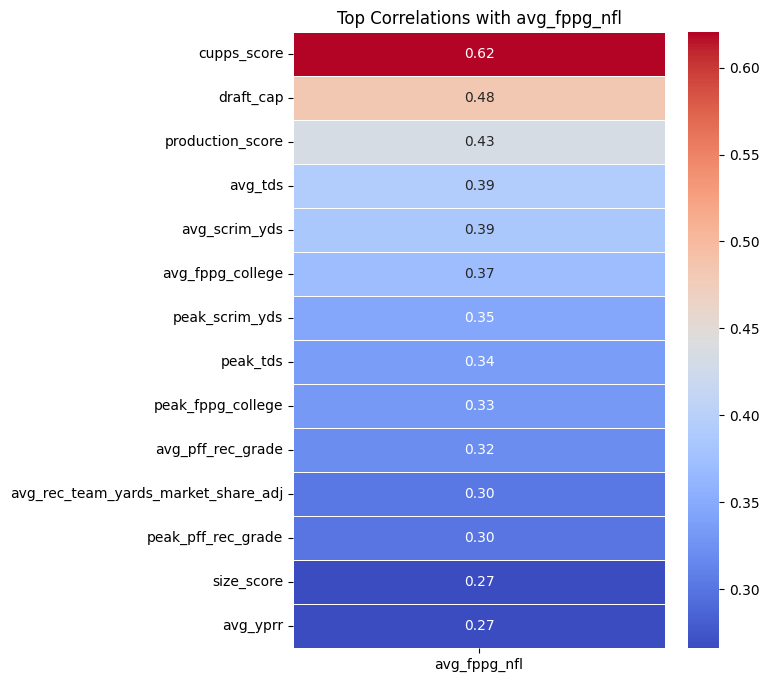

In [118]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Get correlations with avg_fppg_nfl and sort them (using abs since DC is inversely correlated)
correlations = correlation_matrix["avg_fppg_nfl"].dropna().abs().sort_values(ascending=False)

# Select the top N correlated features (excluding avg_fppg_nfl itself)
top_corr_features = correlations.index[1:15]  # Get top 10 correlated features

# Extract the correlation matrix for the selected features
top_corr_matrix = correlation_matrix.loc[top_corr_features, ["avg_fppg_nfl"]]

# Plot the heatmap
plt.figure(figsize=(6, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Top Correlations with avg_fppg_nfl")
plt.show()



In [119]:
# Define features (X) and target variable (y)
X = df.drop(columns=['avg_fppg_nfl'])  # Drop target column from features
y = df['avg_fppg_nfl']  # Target variable

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (404, 31)
Test set size: (101, 31)


In [120]:
#Update these arguments based on the optimizer several cells below (if needed)
xgb_optimized = xgb.XGBRegressor(
    colsample_bytree=0.7,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=300,
    subsample=0.8,
    objective='reg:squarederror',
    random_state=42
)

# Train the model
xgb_optimized.fit(X_train, y_train)

print("✅ XGBoost model training complete!")


✅ XGBoost model training complete!


In [121]:
# Make predictions on the test set
y_pred = xgb_optimized.predict(X_test)

# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

print(f"📊 Model Evaluation:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

📊 Model Evaluation:
MAE: 2.245
RMSE: 2.880
R² Score: 0.461


/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_2541/1850715182.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='coolwarm')


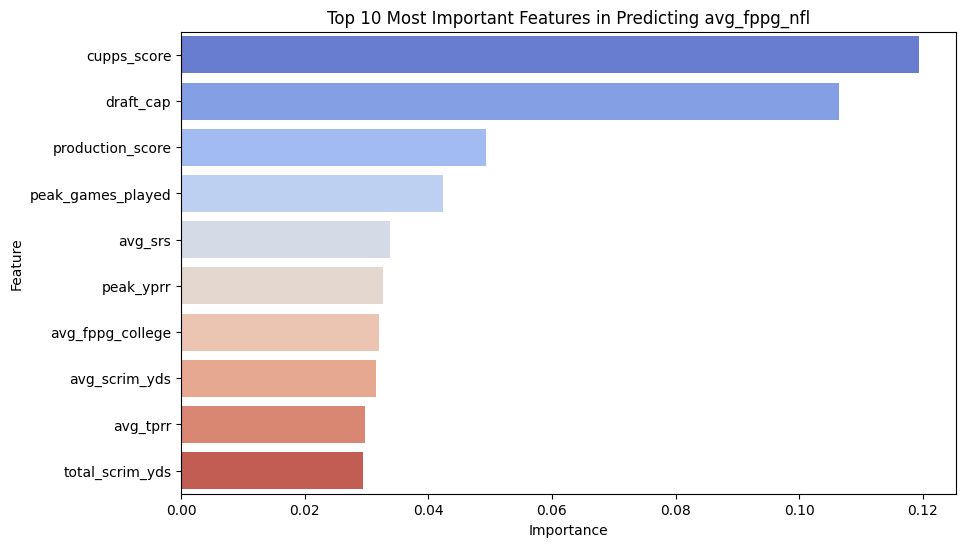

In [122]:
# Get feature importance
importance = xgb_optimized.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='coolwarm')
plt.title("Top 10 Most Important Features in Predicting avg_fppg_nfl")
plt.show()


In [123]:
#Dont run this cell every time...only if we want to debug/identify the best parameters for XGBoost
run_optimizer = False

if run_optimizer:
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }

    xgb_grid = GridSearchCV(
        xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
        param_grid=param_grid,
        cv=3,
        scoring='r2'
    )

    xgb_grid.fit(X_train, y_train)
    print("Best Parameters:", xgb_grid.best_params_)


In [133]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping


# Standardize the features (important for NN stability)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [134]:
# Define NN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # First hidden layer
    Dropout(0.2),  # Dropout to reduce overfitting
    Dense(64, activation='relu'),  # Second hidden layer
    Dropout(0.2),
    Dense(32, activation='relu'),  # Third hidden layer
    Dense(1)  # Output layer (regression, so no activation)
])

# Compile model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

# Summary of the model
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    epochs=1000,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],  # Stops training when val_loss stops improving
    verbose=1
)



/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,465 (56.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 30.2063 - mae: 4.0180 - val_loss: 12.7815 - val_mae: 2.6087
Epoch 2/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.9461 - mae: 2.5516 - val_loss: 12.5424 - val_mae: 2.5790
Epoch 3/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.1434 - mae: 2.5557 - val_loss: 13.1864 - val_mae: 2.7267
Epoch 4/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.2024 - mae: 2.7430 - val_loss: 11.4996 - val_mae: 2.7331
Epoch 5/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.5206 - mae: 2.4520 - val_loss: 10.6036 - val_mae: 2.5755
Epoch 6/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.3883 - mae: 2.4014 - val_loss: 10.1651 - val_mae: 2.4282
Epoch 7/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5477 - mae: 2.1753 - val_loss: 9.4633 - val_mae: 2.3649
Epoch 8/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6130 - mae: 2.2089 - val_loss: 10.7034 - val_mae: 2.5653
Epoch 9/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s

In [135]:
# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)

print("📊 Neural Network Model Evaluation:")
print(f"MAE (Mean Absolute Error): {test_mae:.3f}")
print(f"Loss (MSE): {test_loss:.3f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.2191 - mae: 2.3869
📊 Neural Network Model Evaluation:
MAE (Mean Absolute Error): 2.500
Loss (MSE): 11.277


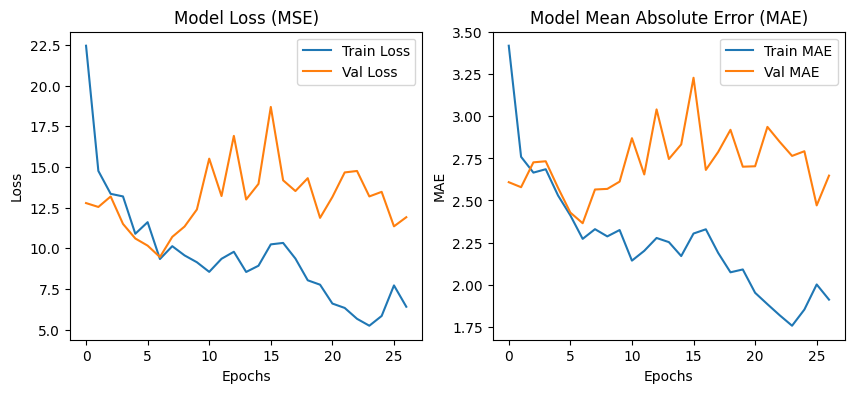

In [136]:
# Plot Loss (MSE)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [137]:
# Make predictions
y_pred_nn = model.predict(X_test_scaled).flatten()

# Evaluate performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse_nn = mean_squared_error(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print("📊 Neural Network Model Final Results:")
print(f"MAE: {mae_nn:.3f}")
print(f"RMSE: {np.sqrt(mse_nn):.3f}")
print(f"R² Score: {r2_nn:.3f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
📊 Neural Network Model Final Results:
MAE: 2.500
RMSE: 3.358
R² Score: 0.267
